# TP1

In [ ]:
#Install package
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib


In [9]:
# import packages

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import random

 ============================================================
 
 ### TPFA (Two-Point Flux Approximation) 

 Find $u_h = (u_K)_{K \in M_h}$ such that for all $K$ in $T_h$:

   $\sum_{\sigma \in F_K \cap F_{int}} \tau_{\sigma} (u_K - u_L)
 + \sum_{\sigma \in F_K \cap F_{ext}} \tau_{\sigma} u_K
 = \int_K f(x) dx$

 with Dirichlet boundary $u=0$ on $\partial \Omega$.

 Here $\Omega=[0,1] \times [0,1]$. We use a cartesian mesh, with cell-centered FV.
 
$A(x,y;\mu) = 2 \mu_1 + \mu_2 \ sin(x+y) \ cos(xy)$

$f(x,y;\mu) = \mu_3 (1-y) + \mu_4 x \ (1-x)$

 ============================================================
 
 $\tau_{\sigma}=|\sigma| \frac{A_K \ A_L} { A_L \ d_{K,\sigma} + A_K \ d_{L,\sigma} }$ on $F_{int}$
 and  $\tau_{\sigma}=|\sigma| \frac{A_K} {  d_{K,\sigma} }$ on $F_{ext}$

 #### 1. Complete the following code:

In [ ]:

# ============================================================
# TPFA (Two-Point Flux Approximation) 
# ============================================================

##### Initialization #########################################
def A_fct(x, y, mu1, mu2):
    # Diffusion parameter
    return ...

def f_fct(x, y, mu3, mu4):
    # Right-hand side term
    return ...

def tau_sigma_int(AK, AL, sigma_len, dK, dL):
    # tau_sigma = |sigma| * AK*AL / (AL*dK + AK*dL)
    return ...

def tau_sigma_ext(AK, sigma_len, dK):
    # tau_sigma = |sigma| * AK / dK
    return ...

##### TPFA assembling #########################################
def assemble_tpfa(Nx=5, Ny=2, mu=(0.99, 0.8, 0.2, 0.78)):
    mu1, mu2, mu3, mu4 = mu
    dx, dy = ... , ...
    volK = ... # area

    # Cell centers x_K
    xc = (np.arange(Nx) + 0.5) * dx
    yc = (np.arange(Ny) + 0.5) * dy
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij") # like matrix indexing
    #plt.plot(Xc, Yc, marker='o', color='k', linestyle='none')
    
    # Fields sampled at x_K
    A = ... # A(x_K;mu) shape of A:  (5, 2)
    f = ...  # f(x_K;mu)

    
    # Indexing K in T_h=(i,j) -> k
    def idK(i, j):  
        return i + Nx * j

    b = (f * volK).reshape(-1, order="F")  # ∫_K f ≈ f(x_K)|K| with same indexing (i + Nx*j)

    # Face geometry on Cartesian grid
    
    # vertical faces (E/W), d_{K,sigma} 
    # horizontal faces (N/S), d_{K,sigma} 
    sigma_len_EW, d_EW = ... , ...
    sigma_len_NS, d_NS = ..., ...

    # ---------------------------------------
    # Assemble by iterating over faces sigma 
    # ---------------------------------------
    rows, cols, data = [], [], []
    
    # 1) Interior faces F_int: add tau_sigma(u_K - u_L) to eq(K), and symmetric to eq(L)
    # 1a) Vertical interior faces between K=(i,j) and L=(i+1,j)
    for j in range(Ny): #Ny vertical edges
        for i in range(Nx - 1): #Nx-2 vertical edges without external boundaries
            K = (i, j)
            L = (i + 1, j) # right neighbor 
            AK = A[K]
            AL = A[L]

            kK = idK(i, j)
            kL = idK(i+1, j)
            
            tau = tau_sigma_int(AK, AL, sigma_len_EW, d_EW, d_EW)

            # Equation for K: +tau*u_K - tau*u_L
            rows += [kK, kK] #line K,K 
            cols += [kK, kL] # col K,L (right neighbor)
            data += [tau, -tau] #[K,L]

            # Equation for L: +tau*u_L - tau*u_K
            rows += [kL, kL] # symetric
            cols += [kL, kK] # left neighbor
            data += [tau, -tau]

    # 1b) Horizontal interior faces between K=(i,j) and L=(i,j+1)
    for j in ...: # For Ny=2, j=0 one edge S/N 
        for i in ...: # For Nx=5, 0....Nx-1 horizontal edge
            K = ...
            L = ...

            kK = ...
            kL = ...

            AK = A[K]
            AL = A[L]
            tau = tau_sigma_int(...)

            rows += [... , ...]
            cols += [... , ...]
            data += [... , ...]

            rows += [... , ...]
            cols += [... , ...]
            data += [... , ...]

    # 2) Boundary faces F_ext (Dirichlet u=0): add tau_sigma * u_K to eq(K)
    # Left boundary (west faces) : i=0
    for j in ...: # j=0,1
        K = ...
        kK = ...
        tau = tau_sigma_ext(...)
        rows.append(kK); cols.append(kK); data.append(tau)

    # Right boundary (east faces) : i=Nx-1 =4
    for j in ...: #0,1
        K = ... 
        kK = ...
        tau = tau_sigma_ext(...)
        rows.append(kK); cols.append(kK); data.append(tau)

    # Bottom boundary (south faces) : j=0 
    for i in range(Nx):#0,1,2,3,4
        K = ...
        kK = ...
        tau = ...
        rows.append(kK); cols.append(kK); data.append(tau)

    # Top boundary (north faces) : j=Ny-1
    for i in ...:
        K = ...
        kK = ...
        tau = tau_sigma_ext(...)
        rows.append(kK); cols.append(kK); data.append(tau)

    # Build sparse system and solve
    N=Nx*Ny
    M = sp.csr_matrix((data, (rows, cols)), shape=(N, N))
    
    return xc,yc,M,b

def solve_tpfa(M,b,Nx,Ny):
    # Solve Mu=b
    u = spla.spsolve(M, b)
    # Back to (Nx,Ny) array with u_K at cell centers
    U = u.reshape((Nx, Ny), order="F")
    return U 


#Draw one solution   
mu = (0.99, 0.8, 0.2, 0.78)
xc, yc,M,b = ...
U = ...

plt.figure()
plt.title("TPFA solution u_K (Dirichlet u=0 on ∂Ω)")
plt.imshow(U.T, origin="lower", extent=[0, 1, 0, 1], aspect="equal")
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# POD
# ============================================================

def Construct_RB(NumberOfSnapshots=50,Nx=50,Ny=50,NumberOfModes=10):
    #Training set Ntrain = NumberOfSnapshots
    print("number of modes: ",NumberOfModes) # N
    mu = (0.99, 0.8, 0.2, 0.78) #first parameter

    Snapshots=[]
    #---------------------------------#
    #      Generate the snapshots     #
    #---------------------------------#
    for i in range(NumberOfSnapshots):
        _, _,M,b = ...
        U = ...
        Snapshots.append(U.flatten(order="F"))
        mu = [...] #random coefficients in [0, 1] 


    #---------------------------------#
    #      POD                        #
    #---------------------------------#

    #(u,v)_L2=sum_K|K| u_k v_k 
    volK = ... #|K|

    #  snapshot correlation matrix C_ij = (u_i,u_j)
    CorrelationMatrix = np.zeros((NumberOfSnapshots, NumberOfSnapshots))
    for i, snapshot1 in enumerate(Snapshots):
        for j, snapshot2 in enumerate(Snapshots):
            if i >= j:
                CorrelationMatrix[i, j] = ...
                CorrelationMatrix[j, i] = ...

    # Then, we compute the eigenvalues/eigenvectors of C (EigenVectors=alpha)
    EigenValues, EigenVectors = np.linalg.eigh(CorrelationMatrix, UPLO="L") #SVD: C eigenVectors=eigenValues eigenVectors

    idx = EigenValues.argsort()[::-1] # sort the eigenvalues
    TotEigenValues = EigenValues[idx]
    TotEigenVectors = EigenVectors[:, idx]

    # retrieve N=NumberOfModes first eigenvalues
    EigenValues = ...
    EigenVectors = ...

    #print("eigenvalues: ",EigenValues)

    RIC = ... #must be close to 0
    print("Relativ Information Content (must be close to 0): ",RIC)

    ChangeOfBasisMatrix = np.zeros((NumberOfModes,NumberOfSnapshots))

    for j in range(NumberOfModes):
        ChangeOfBasisMatrix[j,:] = EigenVectors[:,j]/... #/ normalization

    ReducedBasis = ...

    # orthogonality test
    ...

In [19]:
## ROM L2 projection 

def project_L2(u_full,Phi,Nx,Ny):
    a = ...
    u_proj = ...
    
    return a, u_proj

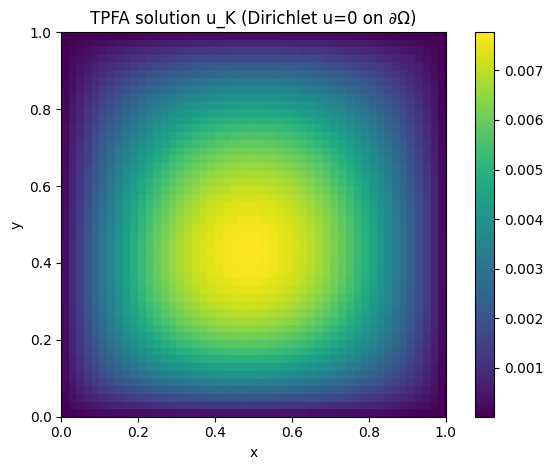

In [20]:
mu = (0.99, 0.8, 0.2, 0.78)
...
xc, yc,M,b = assemble_tpfa(Nx=50, Ny=50,mu=mu)
U = solve_tpfa(M,b)
a,u_proj=project_L2(U,Phi,Nx,Ny)
u_proj=u_proj.reshape(50,50)

plt.figure()
plt.title("TPFA solution u_K (Dirichlet u=0 on ∂Ω)")
plt.imshow(u_proj.T, origin="lower", extent=[0, 1, 0, 1], aspect="equal")
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

In [22]:
# POD-Galerkin
def solve_tpfa_rom(mu, Nx, Ny, Phi):

    
    ...                  
    
    
    
    U_rom = u_rom.reshape((Nx, Ny), order="F")
    return a, U_rom


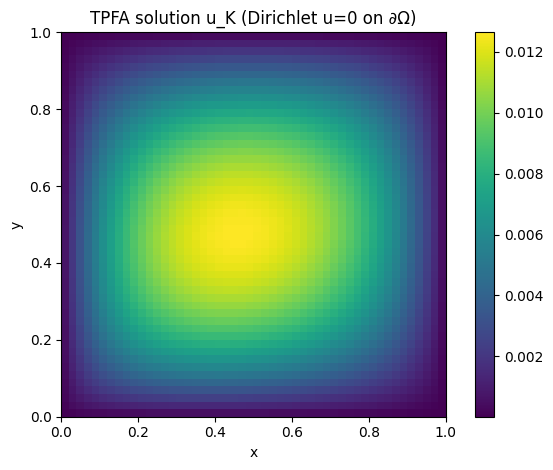

In [23]:
mu = (0.6, 0.5, 0.2, 0.8)
...

(2500,)


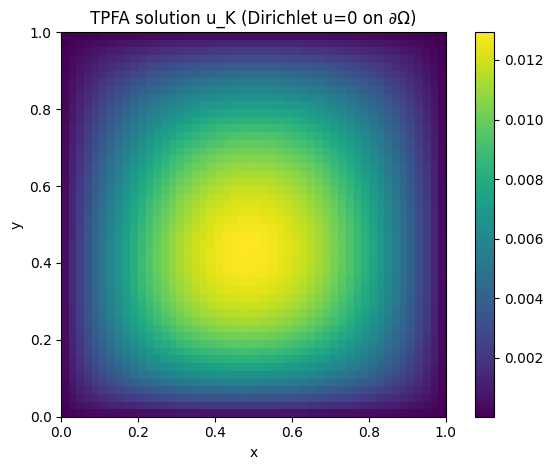

In [71]:
# true sol

xc, yc,M,b = assemble_tpfa(Nx=50, Ny=50,mu=mu)
...


In [ ]:
#### Convergence

#(u,v)_L2=sum_K|K| u_k v_k 

mu = (0.6, 0.5, 0.2, 0.8)


# construct uref:
_,_, M, b = assemble_tpfa(Nx=500, Ny=500,mu=mu)
Uref = solve_tpfa(M,b,500,500)
xc_ref = (np.arange(500) + 0.5) /500
yc_ref = (np.arange(500) + 0.5) /500
interp = RegularGridInterpolator((xc_ref,yc_ref), Uref)


err_true=[]
err_rom=[]

Ns = [...,...,...,...,...]  # choose grid sizes to test
for n in Ns:
    # true sol
    xc, yc, M, b = ...
    U = ...
    #POD_Galerkin 
    Phi=...
    _,Uproj=...

    #restrict uref on fine mesh
    points_new = np.column_stack((xc.flatten(), yc.flatten()))
    Uref_interp = interp(points_new).reshape(n, n)

    ## print l2 error
    abs_true_error = ...
    l2_true_error=...
    print(l2_true_error)
    abs_rom_error = ...
    l2_rom_error=...


    # L2 errors (list)
    err_true.append(l2_true_error)
    err_rom.append(l2_rom_error)

# ---------------------------
# Plot log-log convergence
# ---------------------------
hs = np.array(Ns)
err_true = np.array(err_true)
err_rom = np.array(err_rom)

plt.figure()
plt.loglog(hs, err_true, "o-", label=r"$\|u_{ref}-u\|_{L^2}$")
plt.loglog(hs, 1/(hs**2), "-", label=r"$h^2}$")
plt.loglog(hs, err_rom, "+-", label=r"$\|u_{ref}-u_N\|_{L^2}$")
plt.gca().invert_xaxis()  # optional: smaller h to the right
plt.xlabel(r"$h$")
plt.ylabel(r"$L^2$ error")
plt.grid(True, which="both")
plt.legend()
plt.show()